In [23]:
### imports ###
%load_ext autoreload

import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


import pickle


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
plt.style.use('../report_plots/report.mplstyle')


from sklearn.decomposition import PCA


# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PyTorch version: 1.13.1+cu117
Using device: cuda:0


# Figure 7

In [24]:
mice_sessions = {'Mouse12': ['120806']}
mouse_id = 'Mouse12'
session_id = '120806'
subset = 'hdc'
phase = 'wake'
bin_size = 50
single_spikes = False
data_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/'

dataset_dict = HDC.get_dataset(mouse_id, session_id, phase, subset, bin_size, 
                                    single_spikes, path=data_dir)

checkpoint_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/'
cv_run = -1  # test set is last 1/5 of dataset time series
delay = 0
batch_size = 500  # size of time segments of each batch in dataset below

model_dict = {
                'seed': 123, 
                'll_mode': 'U-qd-3',  # stands for universal count model with exponential-quadratic expansion and C = 3
                'filt_mode': '',  # GLM couplings
                'map_mode': 'svgp-64',  # a sparse variational GP mapping with 64 inducing points
                'x_mode': 'hd-omega-speed-x-y-time',  # observed covariates (behaviour)
                'z_mode': '',  # latent covariates
                'hist_len': 0, 
                'folds': 5, 
                'delays': [0], 
                'neurons': dataset_dict['neurons'], 
                'max_count': dataset_dict['max_count'], 
                'bin_size': dataset_dict['bin_size'], 
                'tbin': dataset_dict['tbin'], 
                'model_name': dataset_dict['name'], 
                'tensor_type': torch.float, 
                'jitter': 1e-5, 
            }

# model and train/test split based on which validation fold is given by cv_run
modelfit, training_results, fit_set, validation_set = lib.models.load_model(
    checkpoint_dir, model_dict, dataset_dict, HDC.enc_used, 
    delay, cv_run, batch_size, gpu_dev
)


units:  85  hdc units:  22


In [25]:
# 2D search, so there will be steps**2 = 10000 covariate vector inputs
rcov = np.empty((0, dataset_dict['covariates']['hd'].shape[0]))

for cov in ['hd', 'omega', 'speed', 'x', 'y', 'time']:
    rcov = np.concatenate((rcov, dataset_dict['covariates'][cov][None, :]), axis=0)
 


hd_trajectory = torch.tensor(rcov[0])
num_samples = list(hd_trajectory.size())[0]
print('num of time samples ', num_samples)
covariates = torch.cat([
    hd_trajectory[:, None],  # sweep over head direction
    *[rcov[k].mean() * torch.ones((num_samples, 1)) for k in range(1, len(rcov))],
    # fill other behavioural covariates at value 0
], dim=-1)[None, None, ...]  # (tr, neurons, steps, covariate dims)

# split into chunks of 4000 datapoints
chunk_size = 4000
chunk_num = int(np.ceil(num_samples / chunk_size))
P_mc = None
for i in range(chunk_num):
    print('batch ', i)
    with torch.no_grad():
        P_mc_chunk = lib.helper.compute_P(
            modelfit, covariates[:,:,i*chunk_size:(i+1)*chunk_size, :], list(range(dataset_dict['neurons'])), MC=30,
            trials=1)  # predictive posterior
    P_mc_chunk = P_mc_chunk.cpu()  # count probabilities of shape (MC, neurons, steps, count)
    if P_mc is None:
        P_mc = P_mc_chunk
    else:
        P_mc = np.concatenate((P_mc, P_mc_chunk), axis=2)

K = P_mc.shape[-1]
counts = torch.arange(K)
hd_mean = (counts[None, None, None, :] * P_mc.astype(float)).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / dataset_dict['tbin']  # in units of Hz
hd_var = ((counts[None, None, None, :] - hd_mean[:,:,:,None])**2 * P_mc).sum(-1)
hd_FF = hd_var / (hd_mean + 1e-12)

_, mean, _ = utils.signal.percentiles_from_samples(hd_rate.float(), [0.05, 0.5, 0.95])
pca = PCA()
activity = torch.transpose(mean, 0, 1)
pca.fit(activity)
components_mean = pca.transform(activity)

_, mean, _ = utils.signal.percentiles_from_samples(hd_FF.float(), [0.05, 0.5, 0.95])
pca = PCA()
activity = torch.transpose(mean, 0, 1)
pca.fit(activity)
components_FF = pca.transform(activity)

num of time samples  43775
batch  0
batch  1
batch  2
batch  3
batch  4
batch  5
batch  6
batch  7
batch  8
batch  9
batch  10


/tmp/ipykernel_9217/994711469.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


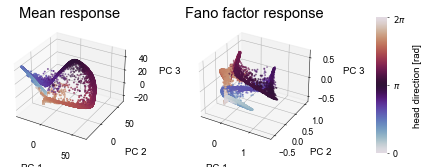

In [31]:
fig = plt.figure(figsize=(7,4))

s=1

gs = gridspec.GridSpec(1, 3, figure=fig, wspace=0.7, width_ratios=[12,12,1])

ax = fig.add_subplot(gs[0], projection='3d')

tuned_angle = dataset_dict['covariates']['hd']

p = ax.scatter(components_mean[::2,0], components_mean[::2, 1], components_mean[::2, 2], s=s, c=tuned_angle[::2], cmap='twilight')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('Mean response', size=15)


ax = fig.add_subplot(gs[1], projection='3d')
p = ax.scatter(components_FF[::3,0], components_FF[::3, 1], components_FF[::3, 2], s=s, c=tuned_angle[::3], cmap='twilight')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('Fano factor response', size=15)


gs1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[2], height_ratios=[1,5,1])
ax = fig.add_subplot(gs1[1])

cmap = mpl.cm.twilight
norm = mpl.colors.Normalize(vmin=0, vmax=2*np.pi)

cbar = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cbar.set_label('head direction [rad]')

cbar.set_ticks([0, np.pi, 2*np.pi])
cbar.ax.set_yticklabels(['0', '$\pi$', '$2\pi$'])  # vertically oriented colorbar
cbar.outline.set_visible(False)

fig.tight_layout()

fig.savefig("/homes/vn283/UCM-interpret/figures/trajectories.pdf", format="pdf", bbox_inches="tight")